In [1]:
import importlib
import matplotlib.pyplot as plt
import numpy as np
from utils import *

i1 = plt.imread('n1_small.jpg')
i2 = plt.imread('n2_small.jpg')
i1 = i1.mean(axis=2)
i2 = i2.mean(axis=2)
h1 = harris_response(i1)
h2 = harris_response(i2)
fig, axs = plt.subplots(ncols=2, figsize=(12, 8))
axs[0].imshow(h1)
axs[1].imshow(h2)
plt.show()

<Figure size 1200x800 with 2 Axes>

In [2]:
x1, y1 = local_max(h1)
x2, y2 = local_max(h2)
x1, y1 = adaptive_suppression(h1, y1, x1)
x2, y2 = adaptive_suppression(h2, y2, x2)

d1, out_x1, out_y1 = extract_descriptors(i1, x1, y1)
d2, out_x2, out_y2 = extract_descriptors(i2, x2, y2)

In [3]:
ix1, ix2 = match_descriptors(d1, d2, out_x1, out_y1, out_x2, out_y2)

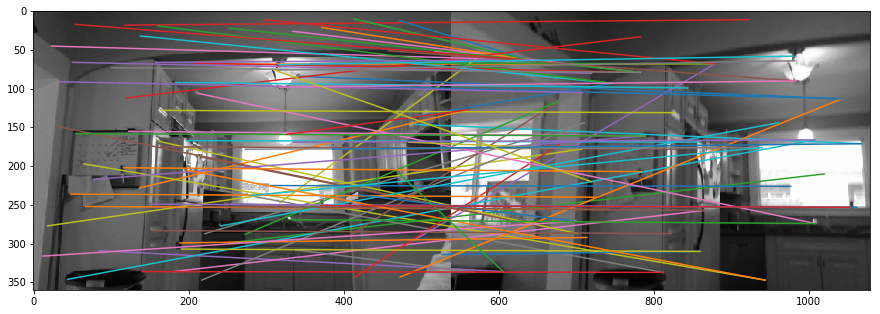

In [4]:
match_x1, match_y1 = unpack(ix1)
match_x2, match_y2 = unpack(ix2)
match_x2 += i1.shape[1]

out_im = np.concatenate((i1, i2), axis=1)
plt.figure(figsize=(15, 12))
plt.imshow(out_im, cmap='gray')
for x, y, xx, yy in zip(match_x1, match_y1, match_x2, match_y2):
    plt.plot([x, xx], [y, yy])
plt.show()

In [5]:
ix1, ix2 = match_descriptors_threshold(d1, d2, out_x1, out_y1, out_x2, out_y2)

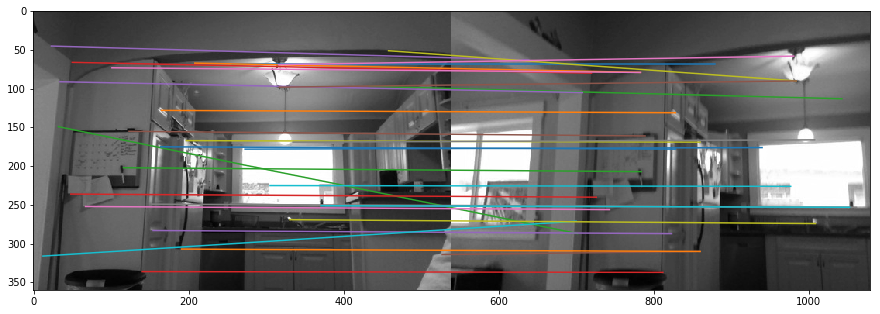

In [6]:
match_x1, match_y1 = unpack(ix1)
match_x2, match_y2 = unpack(ix2)
match_x2 += i1.shape[1]

out_im = np.concatenate((i1, i2), axis=1)
plt.figure(figsize=(15, 12))
plt.imshow(out_im, cmap='gray')
i = 0
for x, y, xx, yy in zip(match_x1, match_y1, match_x2, match_y2):
    plt.plot([x, xx], [y, yy])
    i+=1
plt.show()

In [7]:
match_x2 -= i1.shape[1]
pts1 = np.vstack((match_x1, match_y1)).T
pts2 = np.vstack((match_x2, match_y2)).T

H_test = homography(pts1, pts2)
print(H_test)


[-7.47949289e-04 -2.72097274e-03  8.70630802e-01 -9.35273780e-04
 -1.04144832e-03  4.91916941e-01 -3.94185481e-06 -8.13846128e-06
  3.13149363e-03]


In [199]:
def RANSAC(n_iter, pts1, pts2, sample_size, min_inliers, r=5):
    ''' pts1: np.array with shape (n_matches, 2) '''
    H_best = None
    inliers = []
    for m in range(n_iter):
        indices = np.random.choice(pts1.shape[0], size=sample_size, replace=False)
        indices = sorted(indices)
        
        # split the lists into a sample and the complement
        samp1 = np.zeros(shape=(sample_size, 2))
        samp2 = np.zeros(shape=(sample_size, 2))
        n1 = np.zeros(shape=(pts1.shape[0]-sample_size, 2))
        n2 = np.zeros(shape=(pts2.shape[0]-sample_size, 2))
        j = 0
        k = 0
        for i in range(pts1.shape[0]):
            if i in indices:
                samp1[j] = pts1[i]
                samp2[j] = pts2[i]
                j += 1
            else:
                n1[k] = pts1[i]
                n2[k] = pts2[i]
                k += 1
        
        H_maybe = homography(samp1, samp2)
        H_maybe = np.reshape(H_maybe, (3, 3))
        
        n1_with_ones = np.hstack((n1, np.ones((n1.shape[0], 1))))
        
        Xprime = H_maybe @ n1_with_ones.T # predict n1's points based on H_maybe, compare to locations in n2.
        Xprime = Xprime.T
        Xprime = Xprime[:, :2] / Xprime[:, 2][:, np.newaxis]
        sub_inliers = []
        for pair1, pair2 in zip(Xprime, n2):
            #print(pair1, pair2)
            test_r = residual(pair1[0], pair2[0], pair1[1], pair2[1])
            
            #print('Residual:', test_r, '\n')

            if  test_r < r:
                print(pair1, pair2)
                sub_inliers.append((pair1, pair2))
    
        if len(sub_inliers) > len(inliers) and len(sub_inliers) >= min_inliers:
            inliers = sub_inliers
            H_best = H_maybe
    return H_best, inliers

In [200]:
n_iter = 1000
H_best, inliers = RANSAC(n_iter, pts1, pts2, 20, 1)

print('\n',H_best)

[284.98275096 132.6561204 ] [288. 131.]
[285.80577024 128.2256021 ] [288. 131.]
[283.51569212 132.35772032] [288. 131.]
[252.50051045 159.82956934] [249. 161.]
[245.35610128 158.20489795] [249. 161.]
[181.44220871 238.68216567] [186. 240.]
[245.46687782 161.31184424] [249. 161.]
[244.81340211 159.85481534] [249. 161.]
[250.49333323 156.85179196] [249. 161.]
[317.02438248 166.84309762] [320. 169.]
[286.40091054 176.23034729] [288. 178.]
[250.3445004  156.35540608] [249. 161.]
[292.27795031 131.4921929 ] [288. 131.]
[252.16826093 163.65413728] [249. 161.]
[248.20198528 157.76070604] [249. 161.]
[249.94767129 162.55237236] [249. 161.]
[251.06579503 164.42994028] [249. 161.]
[246.783604   157.70603179] [249. 161.]
[289.62068743 131.87870816] [288. 131.]
[246.86242998 158.069071  ] [249. 161.]
[468.24603287 166.99283458] [468. 166.]
[441.71866171  93.95222253] [444.  90.]
[435.86926237 227.89627493] [437. 226.]
[244.03770787 202.67188433] [244. 207.]
[246.93242116 159.25271396] [249. 161.]


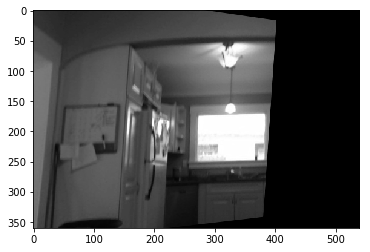

In [202]:
import skimage.transform as skt
# Create a projective transform based on the homography matrix $H$
proj_trans = skt.ProjectiveTransform(H_best)

# Warp the image into image 1's coordinate system
im_trans = skt.warp(i2,proj_trans)

plt.imshow(im_trans, cmap='gray')
plt.show()